Long when red change to green
Short when green change to red

In [97]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import glob
import datetime

logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.CRITICAL)

In [98]:
class Trader:
    def __init__(self, symbol='eth', account_size=100, margin=0.1, fixed_margin=False, leverage=1, fee=0.0004):
        """
        Account size : int
        - Money in the account
        
        Margin : float [0, 1]
        - Percentage of account size for each trade
        
        fixed_margin : bool
        - use fixed margin for each trade
        - True : each trade use initial account size * margin
        - False : each trade use current account size * margin
        
        leverage : int
        
        fee : float
        """
        
        if (margin > 1) or (margin < 0):
            raise Exception('Margin between 0 and 1')
        
        self.symbol = symbol
        self.initial_account_size = account_size
        self._margin = margin
        self.account_size = account_size
        self.leverage = leverage
        self.fixed_margin = fixed_margin
        self.fee = fee
        self.history = []
        self.cache = {
            'entry_price': None,
            'position' : None, # long=1 / short=-1
            'entry_margin' : None
        }
        
    @property
    def margin(self):
        if self.fixed_margin:
            return self.initial_account_size * self._margin
        else:
            return self.account_size * self._margin
        
    @property
    def position(self):
        return self.cache['position']
    
    @position.setter
    def position(self, value):
        if (value == 'long') | (value == 'short') | (value == None):
            self.cache['position'] = value
        else:
            raise Exception('Enter long / short')
        
    @property
    def entry_price(self):
        return self.cache['entry_price']
    
    @entry_price.setter
    def entry_price(self, value):
        self.cache['entry_price'] = value
        
    @property
    def exit_price(self):
        return self.cache['exit_price']
        
    @property
    def entry_margin(self):
        return self.cache['entry_margin']
    
    @entry_margin.setter
    def entry_margin(self, value):
        self.cache['entry_margin'] = value
        
    def reset(self):
        logging.info('Resetting...')
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        self.history = []
        self.account_size = self.initial_account_size
        
    def _clear_cache(self):
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        
    def open_pos(self, price, position, **kwargs):
        """
        1. Get entry price and position
        2. Get other entry information
        3. Compute trade size / notional size (leverage * margin)
        4. Compute Fee (trade size * fee)
        5. Fee reduction
        """
        if self.position != None:
            raise Exception('Has an opening position')
            
        self.entry_price = price
        self.position = position
        self.entry_margin = self.margin
        number_contract = self._compute_number_contract(price)
        fee = self._deduct_fee()
        self._update_cache(entry_fee=fee, number_contract=number_contract, **kwargs)
        logging.info('Enter {position} - price : {price} | size : {size}{symbol}'.format(position=self.position, 
                                                                                         price=price,
                                                                                         size=number_contract,
                                                                                         symbol=self.symbol))

    def close_pos(self, exit_price, **kwargs):
        if (self.position != 'long') & (self.position != 'short'):
            raise Exception('No position')
            
        percentage = self.get_percentage(self.entry_price, exit_price, self.position)
        self._update_account_size(percentage)
        fee = self._deduct_fee()
        self._update_cache(exit_price=exit_price, profit=self.entry_margin * percentage, percentage=percentage, exit_fee=fee, account_size=self.account_size, **kwargs)
        self._append_history()
        logging.info('Close {position} - price : {price} | percentage(%) : {percentage}'.format(position=self.position, 
                                                                                                price=exit_price, 
                                                                                                percentage=percentage*100))
        self._clear_cache()
    
    def get_liquidation_price(self):
        side1both = 1 if self.position == 'long' else -1
        position1both = self.cache['number_contract']
        ep1both = self.entry_price
        mmrb = 0.005
        return (self.account_size - side1both * position1both * ep1both) / (position1both * mmrb - side1both * position1both)
        
    def is_liquidated(self, price):
        if self.position == None:
            raise Exception('No position')
        
        if self.position == 'long':
            return price <= self.get_liquidation_price()
        elif self.position == 'short':
            return price >= self.get_liquidation_price()
        
    def _get_fee(self):
        return self.entry_margin * self.leverage * self.fee

    def _deduct_fee(self):
        fee = self._get_fee()
        self.account_size -= fee
        return fee
    
    def _compute_number_contract(self, price):
        return (self.entry_margin * self.leverage) / price
    
    def get_percentage(self, entry, exit, position):
        if position == None:
            raise Exception('No position')
            
        if position == 'long':
            return (exit - entry) / entry * self.leverage
        elif position == 'short':
            return (entry - exit) / entry * self.leverage
            
            
    def _update_account_size(self, percentage):
        self.account_size += self.entry_margin * percentage 
    
    def _update_cache(self, **kwargs):
        for kwarg in kwargs:
            self.cache[kwarg] = kwargs[kwarg]
    
    def _append_history(self):
        self.history.append(self.cache)

In [99]:
def heikin_ashi(data):
    ha_data = data.copy()
    ha_data['Close'] = (data.Open + data.Low + data.Close + data.High) / 4

    for i in range(data.shape[0]):
        if i > 0:
            ha_data['Open'].iloc[i] = (ha_data.iloc[i-1].Open + ha_data.iloc[i-1].Close) / 2
    ha_data['High'] = ha_data[['High', 'Close', 'Open']].max(axis=1)
    ha_data['Low'] = ha_data[['Low', 'Close', 'Open']].min(axis=1)
    
    return ha_data

In [100]:
data_paths = [
    'data/2022/january/ethusdt.4hour.1january2022-1february2022.csv',
    'data/2022/february/ethusdt.4hour.1-28feb2022.csv',
    'data/2022/march/ethusdt.4hour.1march2022-21march2022.csv'
]

df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
df = df.drop_duplicates(keep='first')
df = df.dropna()

df.index = pd.to_datetime(df.index)
df = df.sort_values('Open time')

In [101]:
df_ha = heikin_ashi(df)
df_ha = df_ha.assign(heikin_ashi=lambda x: (df_ha.Close > df_ha.Open).astype(int)).replace({0:-1})

df_ha = df_ha[df_ha.index.month == 2]

In [102]:
trader = Trader(leverage=1, margin=1, fixed_margin=True)

previous_candle = df_ha.iloc[0].heikin_ashi
for idx, data in df_ha.iloc[1:].iterrows():
    if (previous_candle == -1) & (data.heikin_ashi == 1): # long
        if trader.position != None:
            trader.close_pos(df.loc[idx].Close, exit_date=idx,
                             exit_heikinashi = data.heikin_ashi,
                             exit_previous_heikinashi = previous_candle)
            trader.open_pos(df.loc[idx].Close, 'long', 
                            entry_date = idx,
                            entry_previous_heikinashi = previous_candle,
                            entry_heikinashi = data.heikin_ashi)
        else:
            trader.open_pos(df.loc[idx].Close, 'long', 
                            entry_date = idx,
                            entry_previous_heikinashi = previous_candle,
                            entry_heikinashi = data.heikin_ashi)
    elif (previous_candle == 1) & (data.heikin_ashi == -1): # short
        if trader.position != None:
            trader.close_pos(df.loc[idx].Close, exit_date=idx,
                             exit_heikinashi = data.heikin_ashi,
                             exit_previous_heikinashi = previous_candle)
            trader.open_pos(df.loc[idx].Close, 'short', 
                            entry_date = idx,
                            entry_previous_heikinashi = previous_candle,
                            entry_heikinashi = data.heikin_ashi)
        else:
            trader.open_pos(df.loc[idx].Close, 'short', 
                            entry_date = idx,
                            entry_previous_heikinashi = previous_candle,
                            entry_heikinashi = data.heikin_ashi)
    
    if trader.position != None:
        if trader.is_liquidated(data.Close):
            print('liquidated')
            break
    
    previous_candle = data.heikin_ashi

In [103]:
result = pd.DataFrame(trader.history).set_index('entry_date')

In [104]:
win = result[result.percentage > 0]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

Win rate : 38.46%
Long win rate : 46.67%
Short win rate : 53.33%


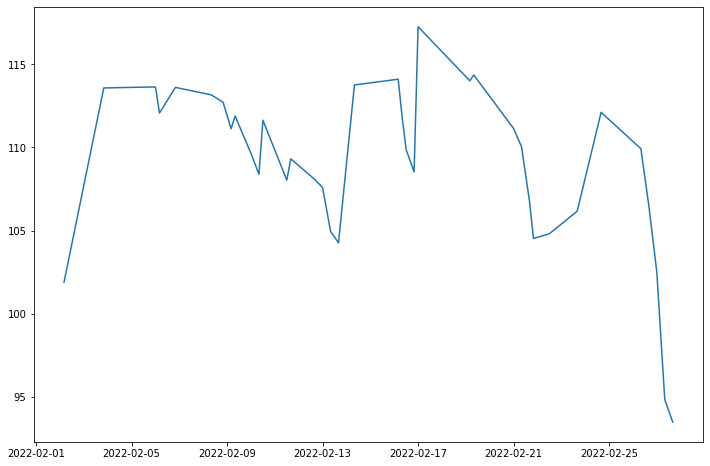

In [105]:
plt.figure(figsize=(12,8))
plt.plot(result.sort_values('entry_date').account_size)